In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, MultiHeadAttention, LayerNormalization

2024-12-27 15:08:40.547710: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-27 15:08:40.551030: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-27 15:08:40.559035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735291420.571775   71217 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735291420.575421   71217 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 15:08:40.590727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
window_size = 30
lstm_units = 50
attention_heads = 2


In [8]:
# Loading and Preprocessing data
df = pd.read_csv('sanima.csv')
df = df.drop(['Percent Change', 'Symbol'], axis = 1)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by="Date", ascending=True).reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2019-12-29,314.0,314.0,311.0,311.0,"6,143.00"
1,2019-12-30,310.0,313.0,310.0,313.0,"14,227.00"
2,2019-12-31,313.0,315.0,312.0,313.0,"15,113.00"
3,2020-01-01,314.0,314.0,312.0,313.0,"5,127.00"
4,2020-01-02,311.0,313.0,311.0,313.0,"11,998.00"


In [9]:
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)
price_columns = ['Open', 'High', 'Low', 'Close']
for col in price_columns: 
    df[col] = df[col].astype(float)

df.head()

,Date,Open,High,Low,Close,Volume
0,2019-12-29,314.0,314.0,311.0,311.0,6143.0
1,2019-12-30,310.0,313.0,310.0,313.0,14227.0
2,2019-12-31,313.0,315.0,312.0,313.0,15113.0
3,2020-01-01,314.0,314.0,312.0,313.0,5127.0
4,2020-01-02,311.0,313.0,311.0,313.0,11998.0


In [13]:
#Technical Indicators
"""A rising moving average indicates that the security is in an uptrend, while a declining moving average indicates a downtrend."""
df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
df['MA50'] = df['Close'].rolling(window=50, min_periods=1).mean()
df.head()

,Date,Open,High,Low,Close,Volume,MA20,MA50
0,2019-12-29,314.0,314.0,311.0,311.0,6143.0,311.000000,311.000000
1,2019-12-30,310.0,313.0,310.0,313.0,14227.0,312.000000,312.000000
2,2019-12-31,313.0,315.0,312.0,313.0,15113.0,312.333333,312.333333
3,2020-01-01,314.0,314.0,312.0,313.0,5127.0,312.500000,312.500000
4,2020-01-02,311.0,313.0,311.0,313.0,11998.0,312.600000,312.600000


In [15]:
df.corr()

,Date,Open,High,Low,Close,Volume,MA20,MA50
Date,1.000000,-0.531568,-0.533622,-0.533788,-0.533872,-0.041558,-0.539155,-0.555387
Open,-0.531568,1.000000,0.997919,0.998145,0.996313,0.495911,0.972986,0.926825
High,-0.533622,0.997919,1.000000,0.997758,0.998351,0.515802,0.970201,0.922863
Low,-0.533788,0.998145,0.997758,1.000000,0.998352,0.491035,0.973095,0.927092
Close,-0.533872,0.996313,0.998351,0.998352,1.000000,0.505996,0.970676,0.924190
Volume,-0.041558,0.495911,0.515802,0.491035,0.505996,1.000000,0.398510,0.309741
MA20,-0.539155,0.972986,0.970201,0.973095,0.970676,0.398510,1.000000,0.972243
MA50,-0.555387,0.926825,0.922863,0.927092,0.924190,0.309741,0.972243,1.000000


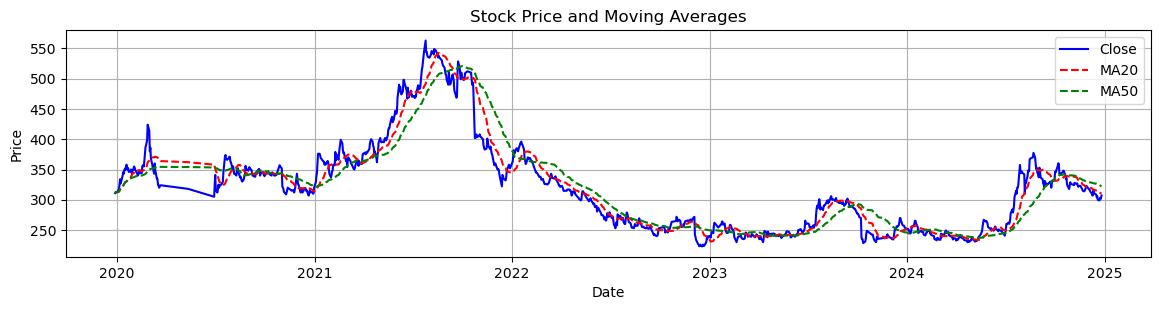

In [17]:
plt.figure(figsize=(14,10))
plt.subplot(3,1,1)
plt.plot(df['Date'],df['Close'], label='Close', color='blue')
plt.plot(df['Date'], df['MA20'], label='MA20', color='red', linestyle='--')
plt.plot(df['Date'], df['MA50'], label='MA50', color='green', linestyle='--')
plt.title('Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()       

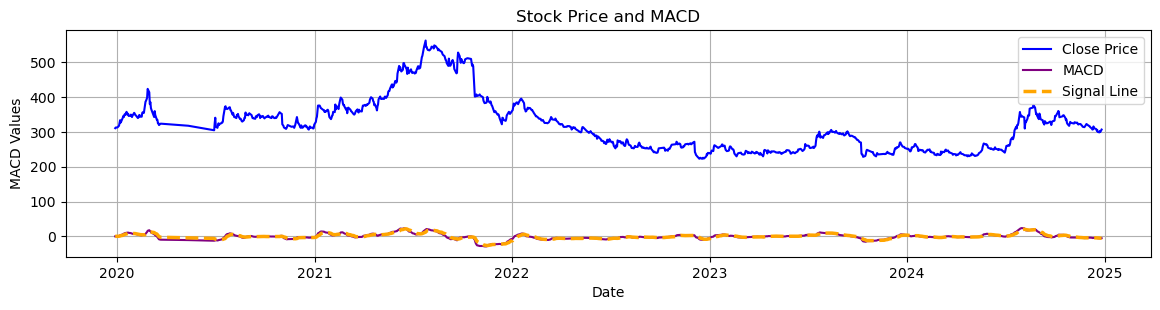

In [22]:
#Calculate and plot MACD AND RSI

"""When the 12-period EMA is above the 26-period EMA, the MACD will be positive (bullish). 
When the 12-period EMA is below the 26-period EMA, the MACD will be negative (bearish)."""

exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1-exp2
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

plt.figure(figsize=(14,10))
plt.subplot(3,1,2)
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue', linewidth=1.5)
plt.plot(df['Date'], df['MACD'], label='MACD', color='purple')
plt.plot(df['Date'], df['Signal_Line'], label='Signal Line', color='orange', linestyle='--', linewidth=2.5)
plt.title('Stock Price and MACD')
plt.xlabel('Date')
plt.ylabel('MACD Values')
plt.legend()
plt.grid(True)
plt.show()